# Proton Recoil Telescope analysis


In [1]:
from pathlib import Path
import requests

# Path to save the extracted files
output_dir = Path("data")
output_file = output_dir / "raw_2025-03-18_ROSY.h5"

if output_file.exists():
    print(f"File already exists: {output_file}")
else:
    # URL of the file
    url = (
        "https://zenodo.org/records/15177190/files/raw_2025-03-18%20ROSY.h5?download=1"
    )

    # Download the file
    response = requests.get(url)
    if response.status_code == 200:
        print("Download successful!")
        # Save the file to the specified directory
        with open(output_file, "wb") as f:
            f.write(response.content)
        print(f"File saved to: {output_file}")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")

File already exists: data/raw_2025-03-18_ROSY.h5


In [2]:
from libra_toolbox.neutron_detection.diamond import prt

data = prt.load_data_from_file(output_file)

['Channel A', 'Channel B', 'Channel C', 'Channel D', 'Coincidence']
Active channels: [ True  True  True  True]
Channel 0: Channel A
Channel 1: Channel B
Channel 2: Channel C
Channel 3: Channel D


### Plot data

In [3]:
import morethemes as mt
mt.set_theme("minimal")

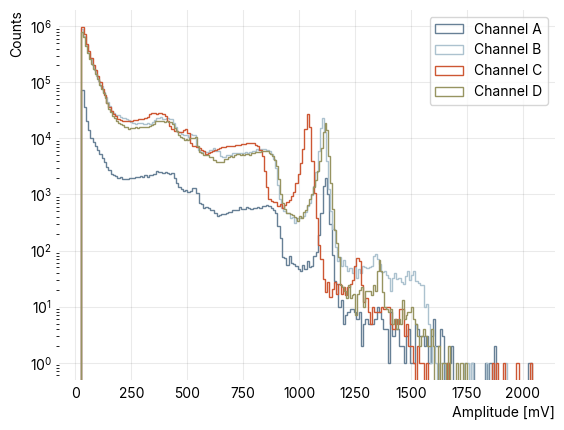

In [4]:
import matplotlib.pyplot as plt

# Plotting amplitudes (analagous to energy, but uncalibrated)

for channel_name in data.keys():
    plt.hist(
        data[channel_name]["amplitudes"],
        bins=200,
        histtype="step",
        label=f"{channel_name}",
    )
plt.xlabel("Amplitude [mV]")
plt.ylabel("Counts")
# plt.title("All Channel Amplitudes")
plt.yscale("log")
plt.legend()
plt.savefig("prt_amplitudes.pdf", bbox_inches="tight")
plt.show()

## Calculate count rate

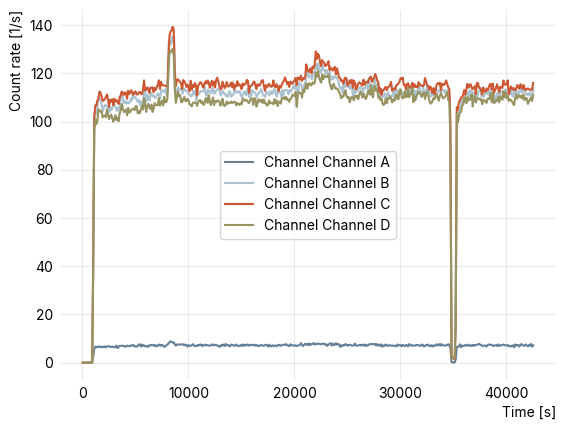

In [5]:
for channel_name in data.keys():

    count_rates, count_rate_bins = prt.get_count_rate(
        data[channel_name]["timestamps"], bin_time=100
    )
    plt.plot(count_rate_bins[:-1], count_rates, label=f"Channel {channel_name}")
plt.xlabel("Time [s]")
plt.ylabel("Count rate [1/s]")
plt.legend()

In [6]:
import json
from datetime import datetime

# -------- read irradiations from logbook ----------------

# read json file from url
url = (
    "https://raw.githubusercontent.com/LIBRA-project/BABY-1L-run-3/refs/heads/main/data/general.json"
)
response = requests.get(url)
if response.status_code == 200:
    print("Download successful!")
    general_data = json.loads(response.content.decode('utf-8'))
else:
    print(f"Failed to download file. HTTP Status Code: {response.status_code}")

print(general_data)


Download successful!
{'general_data': {'description': 'Pure 1 L ClLiF, sparging test', 'run_nb': 3, 'salt': 'ClLiF', 'salt_mass': {'value': 1.88, 'unit': 'kg'}, 'temperature_salt': {'value': 634, 'unit': 'degC', 'note': 'minimum, temperature is non-uniform'}, 'purpose_of_run': 'Attempting to speed up trtium release by including sparging. Changing gas composition to induce release of permeated tritium.'}, 'cover_gas': {'type': 'He', 'pressure_gas_system': {'value': 10, 'unit': 'PSIG'}, 'pressure_gas_crucible': {'value': 3, 'unit': 'PSIG', 'note': 'in steady state, downstream from filters'}, 'flow_rate_sample': {'value': 30, 'unit': 'SCCM'}, 'flow_rate_air': {'value': 10, 'unit': 'SCCM'}, 'switched_to': {'type': '1000 ppm H2 bal. He', 'gas_switch_time': '4/4/2025 15:06'}}, 'secondary_gas': {'type': 'He', 'pressure_gas_system': {'value': 10, 'unit': 'PSIG'}, 'pressure_gas_crucible': {'value': 3, 'unit': 'PSIG', 'note': 'in steady state, downstream from filters'}, 'flow_rate_sample': {'val

In [7]:

# read start time from general.json
all_start_times = []
for generator in general_data["generators"]:
    if generator["enabled"] is False:
        continue
    for irradiation_period in generator["periods"]:
        start_time = datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
        all_start_times.append(start_time)
start_time = min(all_start_times)


irradiations = []
for generator in general_data["generators"]:
    if generator["enabled"] is False:
        continue
    for irradiation_period in generator["periods"]:
        irr_start_time = (
            datetime.strptime(irradiation_period["start"], "%m/%d/%Y %H:%M")
            - start_time
        )
        irr_stop_time = (
            datetime.strptime(irradiation_period["end"], "%m/%d/%Y %H:%M") - start_time
        )


        irr_start_time = irr_start_time.total_seconds()
        irr_stop_time = irr_stop_time.total_seconds()

        irradiations.append([irr_start_time, irr_stop_time])

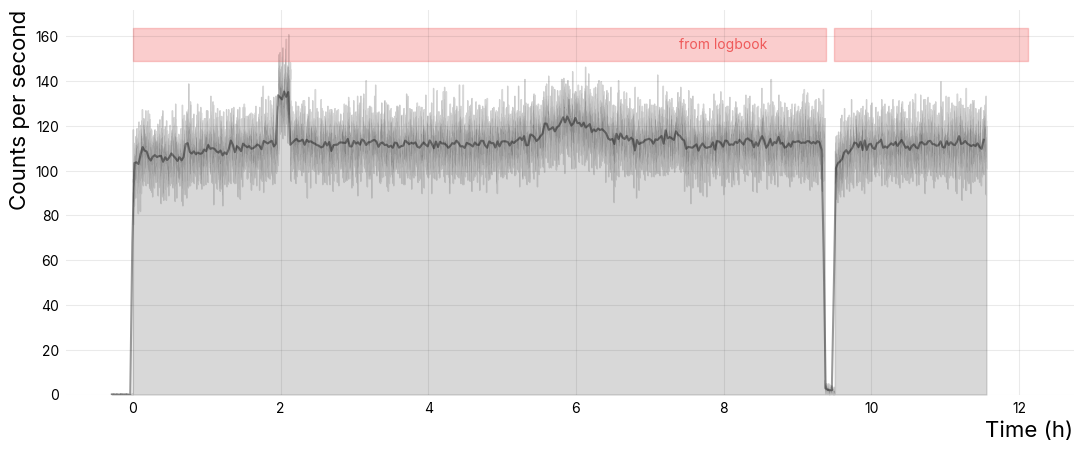

In [8]:
import numpy as np
s_to_h = 1 / 3600
threshold = 40  # counts/s

plt.figure(figsize=(13, 5))

channel_name = "Channel B"
rates, bins = prt.get_count_rate(data[channel_name]["timestamps"], bin_time=2)
start_prt = bins[np.where(rates > threshold)][0]

bins = bins -start_prt

plt.plot(bins[:-1] * s_to_h, rates, color="tab:grey", linewidth=0.051)
plt.fill_between(bins[:-1] * s_to_h, rates, alpha=0.3, color="tab:grey")

rates, bins = prt.get_count_rate(data[channel_name]["timestamps"], bin_time=100)
bins = bins - start_prt

plt.plot(bins[:-1] * s_to_h, rates, color="black", alpha=0.4)

# plot irradiations from logbook
y_val = rates.max() * 1.1
for i, irr in enumerate(irradiations):
    plt.fill_betweenx(
        [y_val, y_val*1.1],
        irr[0] * s_to_h,
        irr[1] * s_to_h,
        color="#EF5B5B",
        alpha=0.3,
    )
plt.annotate(
    "from logbook",
    (7, y_val),
    xytext=(8, y_val*1.05),
    ha="center",
    va="center",
    color="#EF5B5B",
)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.ylabel("Counts per second", fontdict={"fontsize": 16})
plt.xlabel("Time (h)", fontdict={"fontsize": 16})
plt.ylim(bottom=0)

plt.savefig("prt_baby_run_3.pdf")
plt.savefig("prt_baby_run_3.svg")
plt.show()

Plotting coincidences. The separate channels show energy deposited in an individual diamond by a given
coincidence event, and the combined plot shows the total energy of a coincidence event found by
summing the energy deposited in each diamond by the particle

In [9]:
# Only the coincidence window (in seconds) and the coincidence_criteria needs to be changed. Everythign else is automatically done
# coincidence_window in seconds (1e-9 = 1 ns)
# coincidence_citeria:
#      0: Ignore thsi channel for the calculation
#      1: use this channel for coincidence caluclations
#      2: Use this channel for anti-coincidence (no count in the time window for this channel is allowed)
# -> structure [Channel A, Channel B, Channel C, Channel D]


df = prt.calculate_coincidence(
    A_time=data["Channel A"]["timestamps"],
    A_ampl=data["Channel A"]["amplitudes"],
    B_time=data["Channel B"]["timestamps"],
    B_ampl=data["Channel B"]["amplitudes"],
    C_time=data["Channel C"]["timestamps"],
    C_ampl=data["Channel C"]["amplitudes"],
    D_time=data["Channel D"]["timestamps"],
    D_ampl=data["Channel D"]["amplitudes"],
    coincidence_window=100e-9,  # 100 ns
    coincidence_citeria=[1, 1, 1, 0],
)

Ignore: 1, Coincidence: 3, Anti-Coincidence: 0


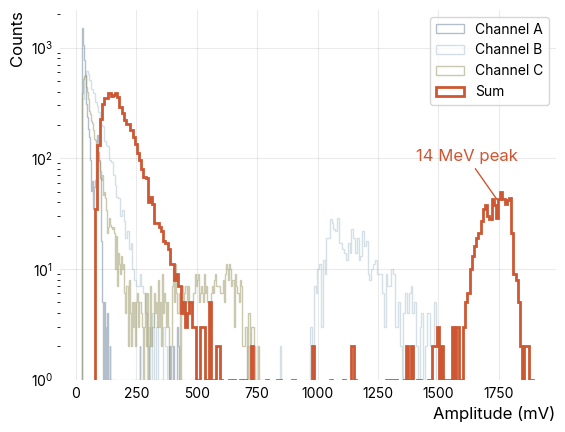

In [13]:
# Channel D is not included because it was not used to calculate coincidences (14 MeV neutrons do not reach channel D)
labels = ["A", "B", "C", "Sum"]
# get current cycle through colors
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

colors = [color_cycle[i] for i in [0, 1, 3, 2]]
for i, label in enumerate(labels):
    if label == "Sum":
        alpha = 1
        linewdith = 2
        new_label = label
    else:
        alpha = 0.5
        linewdith = 1
        new_label = f"Channel {label}"
    plt.hist(
        df[f"{label}_amplitude [mV]"],
        bins=200,
        histtype="step",
        label=new_label,
        alpha=alpha,
        linewidth=linewdith,
        color=colors[i],
    )

plt.annotate(
    "14 MeV peak",
    (1750, 4e1),
    xytext=(-60, 30),
    textcoords="offset points",
    fontsize=12,
    color=colors[i],
    arrowprops=dict(arrowstyle="-", color=colors[i])
)

plt.xlabel("Amplitude (mV)", fontsize=12)
plt.ylabel("Counts", fontsize=12)
# plt.title("All Channel Coincidence Counts")
plt.yscale("log")
plt.ylim(bottom=1e0)
plt.legend()
plt.savefig("prt_baby_run_3_coincidence.pdf", bbox_inches="tight")
plt.show()